# Jungle Chess Classification - Modeling Pipeline

This notebook continues from the EDA/Cleaning notebook.

## Workflow:
1. Load cleaned data
2. Feature Selection
3. Imbalance Handling (4 strategies)
4. Model Training (7 classifiers)
5. Ensemble Methods
6. Cost-Sensitive Classification
7. Hyperparameter Tuning
8. Evaluation & Visualization


In [ ]:
# Clone the repository
!git clone https://github.com/Belaleatsbanana/ml2.git
%cd ml2

In [34]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
colors = ['#e74c3c', '#3498db', '#2ecc71']


# Sklearn
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score,
                             balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score)

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              VotingClassifier, StackingClassifier, BaggingClassifier)
from xgboost import XGBClassifier

# Imbalanced-learn
from imblearn.over_sampling import KMeansSMOTE, SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline


# MLflow
import mlflow
import mlflow.sklearn

RANDOM_SEED = int('GOGU', 36)
np.random.seed(RANDOM_SEED)

In [ ]:
%cd ml2

/content/ml2


In [10]:
%ls

bell/  requirements.txt


In [13]:
# Load cleaned data from CSV
train_data_clean = pd.read_csv('bell/train_data_clean.csv')
test_data_clean = pd.read_csv('bell/test_data_clean.csv')
# Prepare X and y
X_train = train_data_clean.drop('class', axis=1)
y_train = train_data_clean['class']

X_test = test_data_clean.drop('class', axis=1)
y_test = test_data_clean['class']

print(f"\nX_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")


X_train: (4704, 46)
y_train: (4704,)
X_test: (1176, 46)
y_test: (1176,)


---
# Phase 4: Comprehensive Modeling Pipeline

## Workflow:
1. **Feature Selection** - Select best features using correlation and importance
2. **Imbalance Handling** - 4 strategies (None, SVMSMOTE, TomekLinks, SMOTETomek)
3. **Model Training** - 7 classifiers (DT, LR, SVM, KNN, RF, GB, XGB)
4. **Ensemble Methods** - VotingClassifier, StackingClassifier, BaggingClassifier
5. **Hyperparameter Tuning** - StratifiedKFold cross-validation
6. **Evaluation** - Metrics, Learning Curves, Bias-Variance Analysis
7. **MLflow Logging** - Track everything


In [14]:
# MLflow Setup
mlflow.set_experiment("Jungle_Chess_Classification")
print("✅ MLflow experiment set!")

# MLflow logging functions
def log_metrics_to_mlflow(y_true, y_pred, y_proba=None, prefix=''):
    """Log classification metrics to MLflow"""
    metrics = {
        f'{prefix}accuracy': accuracy_score(y_true, y_pred),
        f'{prefix}precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        f'{prefix}recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
        f'{prefix}f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
        f'{prefix}balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        f'{prefix}mcc': matthews_corrcoef(y_true, y_pred),
        f'{prefix}cohen_kappa': cohen_kappa_score(y_true, y_pred)
    }
    if y_proba is not None:
        try:
            metrics[f'{prefix}roc_auc'] = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
        except:
            pass
    mlflow.log_metrics(metrics)
    return metrics

def log_confusion_matrix_plot(y_true, y_pred, title='Confusion Matrix'):
    """Log confusion matrix as artifact"""
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Black', 'White', 'Draw'], yticklabels=['Black', 'White', 'Draw'])
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.tight_layout()
    filename = 'confusion_matrix.png'
    plt.savefig(filename, dpi=100)
    mlflow.log_artifact(filename)
    plt.show()
    plt.close()

2025/12/20 12:10:27 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/20 12:10:27 INFO mlflow.store.db.utils: Updating database tables
2025/12/20 12:10:27 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/20 12:10:27 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/20 12:10:27 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2025/12/20 12:10:27 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2025/12/20 12:10:27 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2025/12/20 12:10:27 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2025/12/20 12:10:27 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2025/12/20 12:10:27 INFO alembic.runtime.migration: Running 

✅ MLflow experiment set!


## Step 1: Feature Selection

Using multiple methods:
1. Correlation with target
2. Random Forest feature importance
3. Select top features


In [15]:
# Method 1: Correlation with target
correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)
print("\n1. Top 15 features by correlation with target:")
print(correlations.head(15))

# Method 2: Random Forest importance
rf_selector = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)
rf_selector.fit(X_train, y_train)
importances = pd.Series(rf_selector.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\n2. Top 15 features by Random Forest importance:")
print(importances.head(15))

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



1. Top 15 features by correlation with target:
fastest_to_den                                 0.630958
closest_to_den                                 0.630958
white_unopposed_to_den_quick_detour            0.551242
black_unopposed_to_den_quick_detour            0.515861
white_piece0_movesto_black_den                 0.447253
white_piece0_distanceto_black_den              0.447253
white_piece0_rank                              0.395719
black_piece0_movesto_white_den                 0.365632
black_piece0_distanceto_white_den              0.365632
black_piece0_rank                              0.315088
white_piece0_advanced                          0.309420
white_piece0_movesto_white_den                 0.290263
white_piece0_distanceto_white_den              0.290263
black_piece0_advanced                          0.262201
black_piece0_distanceto_white_piece0_parity    0.253175
dtype: float64

2. Top 15 features by Random Forest importance:
white_piece0_distanceto_black_piece0_parity    0

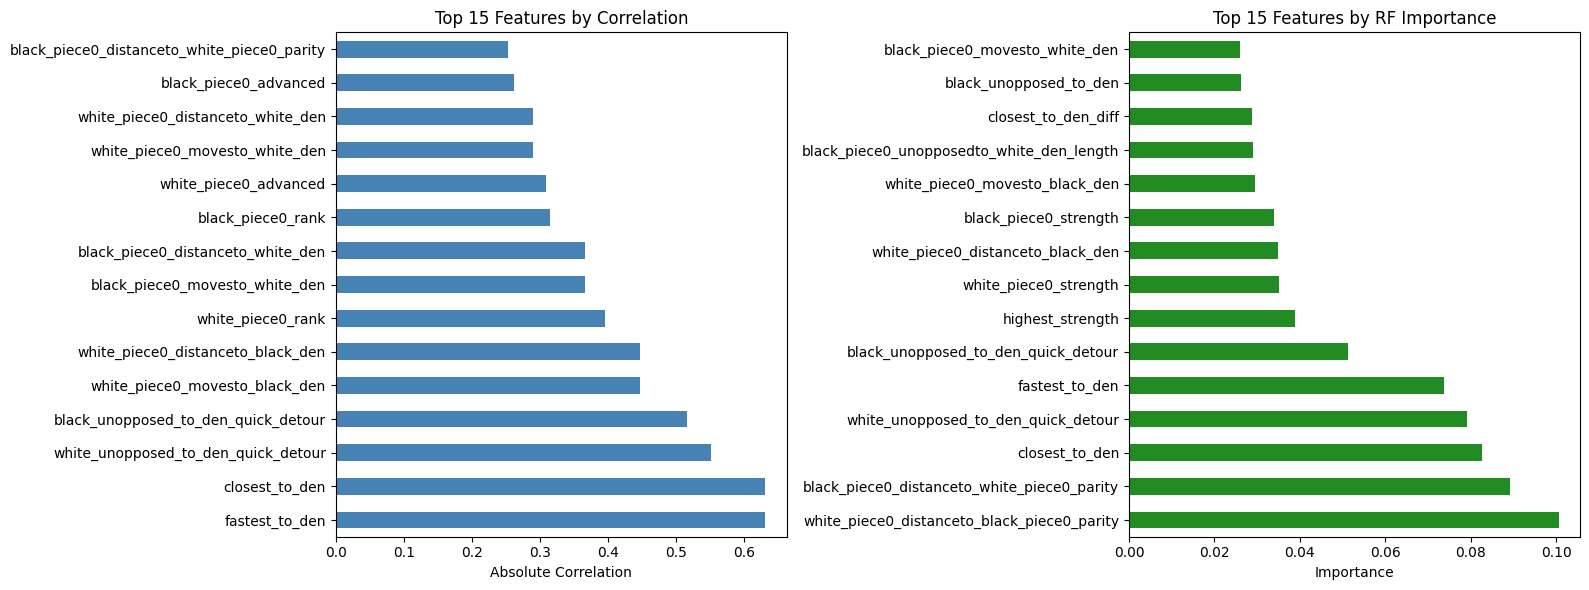

In [16]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

correlations.head(15).plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Top 15 Features by Correlation')
axes[0].set_xlabel('Absolute Correlation')

importances.head(15).plot(kind='barh', ax=axes[1], color='forestgreen')
axes[1].set_title('Top 15 Features by RF Importance')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

In [17]:
# Select top features (union of top 20 from each method)
top_corr_features = set(correlations.head(20).index)
top_rf_features = set(importances.head(20).index)
selected_features = list(top_corr_features.union(top_rf_features))

print(f"\n3. Selected {len(selected_features)} features (union of top 20 from each method)")
print(f"Selected features: {selected_features}")

# Create selected feature datasets
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"\nX_train_selected shape: {X_train_selected.shape}")
print(f"X_test_selected shape: {X_test_selected.shape}")


3. Selected 29 features (union of top 20 from each method)
Selected features: ['white_piece0_strength', 'black_piece0_distanceto_white_den', 'white_piece0_in_trap', 'white_piece0_distanceto_black_den', 'white_piece0_rank', 'black_piece0_in_trap', 'white_unopposed_to_den_quick_detour', 'closest_to_den_diff', 'black_piece0_strength', 'black_piece0_rank', 'black_piece0_movesto_black_den', 'black_piece0_distanceto_black_den', 'white_piece0_movesto_black_den', 'highest_strength', 'white_piece0_distanceto_white_den', 'white_piece0_advanced', 'white_unopposed_to_den', 'black_piece0_unopposedto_white_den_length', 'white_piece0_distanceto_black_piece0_parity', 'fastest_to_den_diff', 'black_piece0_movesto_white_den', 'black_unopposed_to_den', 'closest_to_den', 'white_piece0_movesto_white_den', 'black_piece0_distanceto_white_piece0_parity', 'black_piece0_advanced', 'fastest_to_den', 'white_piece0_unopposedto_black_den_length', 'black_unopposed_to_den_quick_detour']

X_train_selected shape: (4704

## Step 2: Imbalance Handling Strategies

We'll create 4 different pipelines using **ImbPipeline**:

| Pipeline | Strategy | Type | Description |
|----------|----------|------|-------------|
| 1 | **None** | Baseline | No resampling |
| 2 | **KMeansSMOTE** | Oversampling | KMeans clustering + SMOTE |
| 3 | **ClusterCentroids** | Undersampling | Cluster-based centroid sampling |
| 4 | **SMOTEENN** | Combined | SMOTE + Edited Nearest Neighbors |

Using `ImbPipeline` from `imblearn.pipeline` for clean, reproducible code.


In [21]:
# Store resampled datasets
resampled_data = {}

In [32]:
# Calculate Sampling Strategy for Multi-Class Resampling
X_np = X_train_selected.values
y_np = y_train.values

# Get original class distribution
unique_classes, class_counts = np.unique(y_np, return_counts=True)
original_dist = dict(zip(unique_classes, class_counts))

# Find majority class
majority_class = max(original_dist, key=original_dist.get)
majority_count = original_dist[majority_class]


# This brings minority from ~13% to ~20-25%
target_minority_ratio = 0.5
target_minority_count = int(majority_count * target_minority_ratio)


# Oversampling strategy: increase minority classes, keep majority unchanged
oversample_strategy = {}
for cls, cnt in original_dist.items():
    if cnt < target_minority_count:
        oversample_strategy[cls] = target_minority_count 
    else:
        oversample_strategy[cls] = cnt 

# Undersampling strategy: reduce majority, keep minority unchanged
undersample_target = int(majority_count * 0.7)
undersample_strategy = {}
for cls, cnt in original_dist.items():
    if cnt == majority_count:
        undersample_strategy[cls] = undersample_target
    else:
        undersample_strategy[cls] = cnt


for cls, cnt in oversample_strategy.items():
    orig = original_dist[cls]
    change = cnt - orig

for cls, cnt in undersample_strategy.items():
    orig = original_dist[cls]
    change = cnt - orig

In [36]:
# Apply Resampling Strategies

# 1. No Resampling (Baseline)
resampled_data['None'] = (X_np.copy(), y_np.copy())

# 2. KMeansSMOTE (Oversampling)
kmeans_smote = KMeansSMOTE(
    sampling_strategy=oversample_strategy,
    random_state=RANDOM_SEED,
    k_neighbors=3,
    cluster_balance_threshold=0.1
)
X_km, y_km = kmeans_smote.fit_resample(X_np, y_np)
resampled_data['KMeansSMOTE'] = (X_km, y_km)


# 3. ClusterCentroids (Undersampling)
cluster_centroids = ClusterCentroids(
    sampling_strategy=undersample_strategy,
    random_state=RANDOM_SEED
)
X_cc, y_cc = cluster_centroids.fit_resample(X_np, y_np)
resampled_data['ClusterCentroids'] = (X_cc, y_cc)


# 4. SMOTEENN (Combined)
smoteenn = SMOTEENN(
    sampling_strategy=oversample_strategy,
    random_state=RANDOM_SEED
)
X_se, y_se = smoteenn.fit_resample(X_np, y_np)
resampled_data['SMOTEENN'] = (X_se, y_se)


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (788) found smaller than n_clusters (1753). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (245) found smaller than n_clusters (618). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1059) found smaller than n_clusters (1633). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


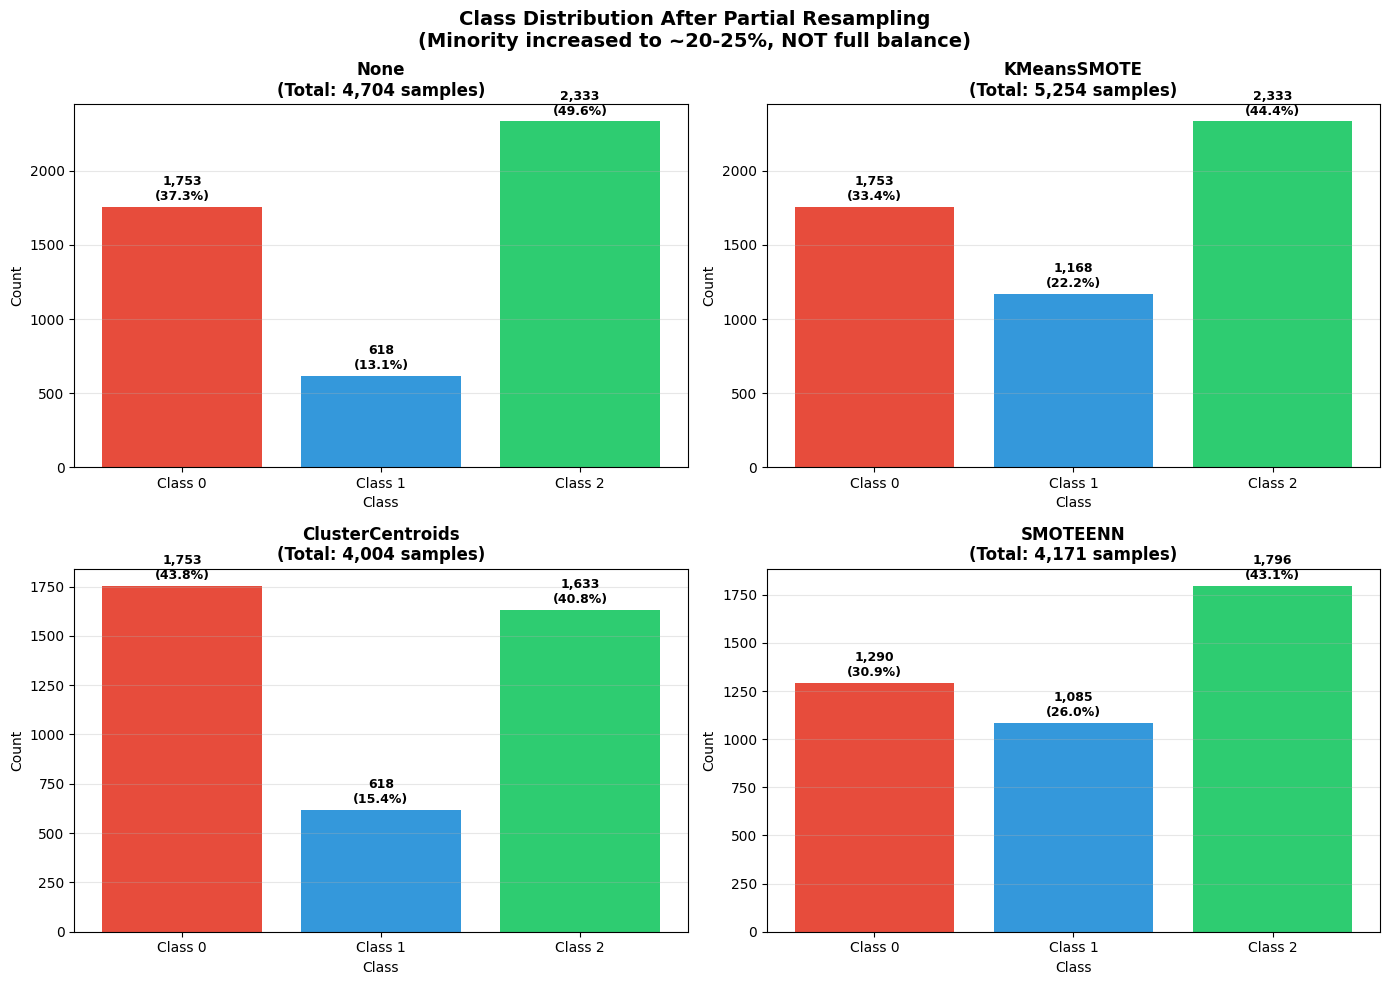

In [39]:
# Visualize Resampling Results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (name, (X_res, y_res)) in enumerate(resampled_data.items()):
    unique, counts = np.unique(y_res, return_counts=True)
    total = sum(counts)
    percentages = [c/total*100 for c in counts]
    
    bars = axes[idx].bar(unique, counts, color=colors[:len(unique)])
    axes[idx].set_title(f'{name}\n(Total: {total:,} samples)', fontweight='bold', fontsize=12)
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('Count')
    axes[idx].set_xticks(unique)
    axes[idx].set_xticklabels([f'Class {c}' for c in unique])
    axes[idx].grid(axis='y', alpha=0.3)
    
    for bar, c, pct in zip(bars, counts, percentages):
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.02,
                      f'{c:,}\n({pct:.1f}%)', ha='center', fontsize=9, fontweight='bold')

plt.suptitle('Class Distribution After Partial Resampling\n(Minority increased to ~20-25%, NOT full balance)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 3: Define Base Models

7 classification models:
1. Decision Tree
2. Logistic Regression
3. SVM
4. KNN
5. Random Forest
6. Gradient Boosting
7. XGBoost


In [41]:
# Define Base Models
base_models = {
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_SEED),
    'LogisticRegression': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000),
    'SVM': SVC(random_state=RANDOM_SEED, probability=True),
    'KNN': KNeighborsClassifier(),
    'RandomForest': RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(random_state=RANDOM_SEED),
    'XGBoost': XGBClassifier(random_state=RANDOM_SEED, eval_metric='mlogloss', use_label_encoder=False)
}

## Step 4: Train Base Models on All Resampled Datasets

Train each model on each resampling strategy and log to MLflow.


In [42]:
# Train Models using ImbPipeline and resampled_data

# Store results
results = []
trained_pipelines = {}

# Prepare test data (using selected features)
X_test_np = X_test_selected.values
y_test_np = y_test.values


# Train on each resampled dataset from resampled_data
for resample_name, (X_res, y_res) in resampled_data.items():
    
    # Scale the resampled data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_res)
    X_test_scaled = scaler.transform(X_test_np)
    
    for model_name, model in base_models.items():

        model_clone = model.__class__(**model.get_params())     # Clone model
        
        run_name = f"{model_name}_{resample_name}"
        
        with mlflow.start_run(run_name=run_name):
            mlflow.log_param('model', model_name)
            mlflow.log_param('resampling', resample_name)
            mlflow.log_param('n_features', X_res.shape[1])
            mlflow.log_param('n_train_samples', X_res.shape[0])
            
            # Use scaled data for distance-based models
            if model_name in ['SVM', 'LogisticRegression', 'KNN']:
                model_clone.fit(X_train_scaled, y_res)
                y_pred = model_clone.predict(X_test_scaled)
                y_proba = model_clone.predict_proba(X_test_scaled) if hasattr(model_clone, 'predict_proba') else None
            else:
                model_clone.fit(X_res, y_res)
                y_pred = model_clone.predict(X_test_np)
                y_proba = model_clone.predict_proba(X_test_np) if hasattr(model_clone, 'predict_proba') else None
            
            # Calculate metrics
            acc = accuracy_score(y_test_np, y_pred)
            f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
            prec = precision_score(y_test_np, y_pred, average='macro', zero_division=0)
            rec = recall_score(y_test_np, y_pred, average='macro', zero_division=0)
            
            log_metrics_to_mlflow(y_test_np, y_pred, y_proba, prefix='test_')
            
            results.append({
                'Model': model_name,
                'Resampling': resample_name,
                'Accuracy': acc,
                'F1_Macro': f1,
                'Precision': prec,
                'Recall': rec,
                'Status': 'SUCCESS'
            })
            
            trained_pipelines[run_name] = model_clone
            print(f"{model_name}: Acc={acc:.4f}, F1={f1:.4f}")
            


results_df = pd.DataFrame(results)
print("\n\ndone")

DecisionTree: Acc=0.9906, F1=0.9848
LogisticRegression: Acc=0.8631, F1=0.7922
SVM: Acc=0.9864, F1=0.9807
KNN: Acc=0.9881, F1=0.9818
RandomForest: Acc=0.9889, F1=0.9834
GradientBoosting: Acc=0.9906, F1=0.9870


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:10:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: Acc=0.9889, F1=0.9834
DecisionTree: Acc=0.9881, F1=0.9820
LogisticRegression: Acc=0.8571, F1=0.8057
SVM: Acc=0.9881, F1=0.9835
KNN: Acc=0.9881, F1=0.9818
RandomForest: Acc=0.9906, F1=0.9863
GradientBoosting: Acc=0.9923, F1=0.9883


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:10:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: Acc=0.9923, F1=0.9875
DecisionTree: Acc=0.9906, F1=0.9863
LogisticRegression: Acc=0.8512, F1=0.7903
SVM: Acc=0.9881, F1=0.9844
KNN: Acc=0.9864, F1=0.9792
RandomForest: Acc=0.9906, F1=0.9862
GradientBoosting: Acc=0.9923, F1=0.9905


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:10:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: Acc=0.9906, F1=0.9862
DecisionTree: Acc=0.9796, F1=0.9734
LogisticRegression: Acc=0.8486, F1=0.8053
SVM: Acc=0.9762, F1=0.9703
KNN: Acc=0.9677, F1=0.9573
RandomForest: Acc=0.9821, F1=0.9747
GradientBoosting: Acc=0.9796, F1=0.9741


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:10:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: Acc=0.9796, F1=0.9715


done


In [43]:
# Results Summary

# Pivot table for better visualization
pivot_acc = results_df.pivot(index='Model', columns='Resampling', values='Accuracy')
pivot_f1 = results_df.pivot(index='Model', columns='Resampling', values='F1_Macro')

print("\nAccuracy by Model and Resampling:")
print(pivot_acc.round(4).to_string())

print("\nF1 Macro by Model and Resampling:")
print(pivot_f1.round(4).to_string())


Accuracy by Model and Resampling:
Resampling          ClusterCentroids  KMeansSMOTE    None  SMOTEENN
Model                                                              
DecisionTree                  0.9906       0.9881  0.9906    0.9796
GradientBoosting              0.9923       0.9923  0.9906    0.9796
KNN                           0.9864       0.9881  0.9881    0.9677
LogisticRegression            0.8512       0.8571  0.8631    0.8486
RandomForest                  0.9906       0.9906  0.9889    0.9821
SVM                           0.9881       0.9881  0.9864    0.9762
XGBoost                       0.9906       0.9923  0.9889    0.9796

F1 Macro by Model and Resampling:
Resampling          ClusterCentroids  KMeansSMOTE    None  SMOTEENN
Model                                                              
DecisionTree                  0.9863       0.9820  0.9848    0.9734
GradientBoosting              0.9905       0.9883  0.9870    0.9741
KNN                           0.9792       0.9

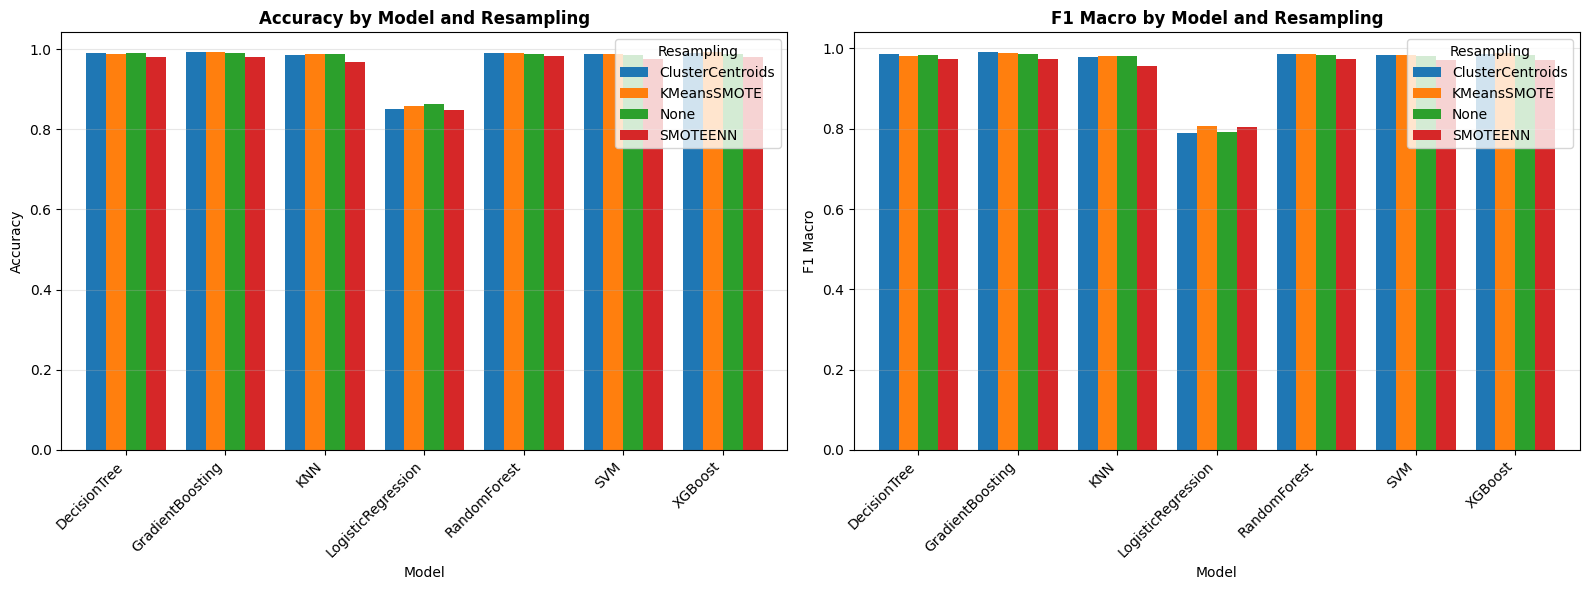

In [44]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

pivot_acc.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('Accuracy by Model and Resampling', fontweight='bold')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Accuracy')
axes[0].legend(title='Resampling')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

pivot_f1.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('F1 Macro by Model and Resampling', fontweight='bold')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('F1 Macro')
axes[1].legend(title='Resampling')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [45]:
# Best model per resampling
print("\nBest Model per Resampling Strategy (by F1):")
for resample in resampled_data.keys():
    best_row = results_df[results_df['Resampling'] == resample].nlargest(1, 'F1_Macro').iloc[0]
    print(f"{resample}: {best_row['Model']} (F1={best_row['F1_Macro']:.4f})")


Best Model per Resampling Strategy (by F1):
None: GradientBoosting (F1=0.9870)
KMeansSMOTE: GradientBoosting (F1=0.9883)
ClusterCentroids: GradientBoosting (F1=0.9905)
SMOTEENN: RandomForest (F1=0.9747)


## Step 5: Ensemble Methods

Create ensembles for each resampling strategy:
1. **VotingClassifier** - Soft voting of top 3 models
2. **StackingClassifier** - Stack with LogisticRegression meta-learner
3. **BaggingClassifier** - Bagging with best base model


In [ ]:
# Ensemble Methods using resampled_data

ensemble_results = []

for resample_name, (X_res, y_res) in resampled_data.items():
    print(f"\n{'='*50}")
    print(f"Ensembles for: {resample_name}")
    print(f"{'='*50}")
    
    # Scale data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_res)
    X_test_scaled = scaler.transform(X_test_np)
    
    # 1. VotingClassifier
    voting_clf = VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100)),
            ('xgb', XGBClassifier(random_state=RANDOM_SEED, eval_metric='mlogloss', use_label_encoder=False)),
            ('gb', GradientBoostingClassifier(random_state=RANDOM_SEED))
        ],
        voting='soft'
    )
    
    with mlflow.start_run(run_name=f'VotingClassifier_{resample_name}'):
        mlflow.log_param('ensemble', 'VotingClassifier')
        mlflow.log_param('resampling', resample_name)
        
        try:
            voting_clf.fit(X_res, y_res)
            y_pred = voting_clf.predict(X_test_np)
            y_proba = voting_clf.predict_proba(X_test_np)
            
            acc = accuracy_score(y_test_np, y_pred)
            f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
            log_metrics_to_mlflow(y_test_np, y_pred, y_proba, prefix='test_')
            
            ensemble_results.append({'Ensemble': 'VotingClassifier', 'Resampling': resample_name,
                                     'Accuracy': acc, 'F1_Macro': f1})
            print(f"  ✅ VotingClassifier: Acc={acc:.4f}, F1={f1:.4f}")
        except Exception as e:
            print(f"  ❌ VotingClassifier failed: {str(e)[:50]}")
            ensemble_results.append({'Ensemble': 'VotingClassifier', 'Resampling': resample_name,
                                     'Accuracy': 0, 'F1_Macro': 0})
    
    # 2. StackingClassifier
    stacking_clf = StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=50)),
            ('dt', DecisionTreeClassifier(random_state=RANDOM_SEED)),
            ('knn', KNeighborsClassifier())
        ],
        final_estimator=LogisticRegression(random_state=RANDOM_SEED, max_iter=1000),
        cv=3
    )
    
    with mlflow.start_run(run_name=f'StackingClassifier_{resample_name}'):
        mlflow.log_param('ensemble', 'StackingClassifier')
        mlflow.log_param('resampling', resample_name)
        
        try:
            stacking_clf.fit(X_train_scaled, y_res)
            y_pred = stacking_clf.predict(X_test_scaled)
            y_proba = stacking_clf.predict_proba(X_test_scaled)
            
            acc = accuracy_score(y_test_np, y_pred)
            f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
            log_metrics_to_mlflow(y_test_np, y_pred, y_proba, prefix='test_')
            
            ensemble_results.append({'Ensemble': 'StackingClassifier', 'Resampling': resample_name,
                                     'Accuracy': acc, 'F1_Macro': f1})
            print(f"  ✅ StackingClassifier: Acc={acc:.4f}, F1={f1:.4f}")
        except Exception as e:
            print(f"  ❌ StackingClassifier failed: {str(e)[:50]}")
            ensemble_results.append({'Ensemble': 'StackingClassifier', 'Resampling': resample_name,
                                     'Accuracy': 0, 'F1_Macro': 0})
    
    # 3. BaggingClassifier
    bagging_clf = BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=RANDOM_SEED),
        n_estimators=50,
        random_state=RANDOM_SEED,
        n_jobs=-1
    )
    
    with mlflow.start_run(run_name=f'BaggingClassifier_{resample_name}'):
        mlflow.log_param('ensemble', 'BaggingClassifier')
        mlflow.log_param('resampling', resample_name)
        
        try:
            bagging_clf.fit(X_res, y_res)
            y_pred = bagging_clf.predict(X_test_np)
            y_proba = bagging_clf.predict_proba(X_test_np)
            
            acc = accuracy_score(y_test_np, y_pred)
            f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
            log_metrics_to_mlflow(y_test_np, y_pred, y_proba, prefix='test_')
            
            ensemble_results.append({'Ensemble': 'BaggingClassifier', 'Resampling': resample_name,
                                     'Accuracy': acc, 'F1_Macro': f1})
            print(f"  ✅ BaggingClassifier: Acc={acc:.4f}, F1={f1:.4f}")
        except Exception as e:
            print(f"  ❌ BaggingClassifier failed: {str(e)[:50]}")
            ensemble_results.append({'Ensemble': 'BaggingClassifier', 'Resampling': resample_name,
                                     'Accuracy': 0, 'F1_Macro': 0})

ensemble_df = pd.DataFrame(ensemble_results)
print("\n✅ All ensembles trained!")

In [ ]:
# Ensemble Results Summary
print("="*60)
print("ENSEMBLE RESULTS SUMMARY")
print("="*60)

pivot_ens = ensemble_df.pivot(index='Ensemble', columns='Resampling', values='F1_Macro')
print("\nF1 Macro by Ensemble and Resampling:")
print(pivot_ens.round(4).to_string())

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
pivot_ens.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Ensemble F1 Macro by Resampling Strategy', fontweight='bold')
ax.set_xlabel('Ensemble Method')
ax.set_ylabel('F1 Macro')
ax.legend(title='Resampling')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Best overall
best_ens = ensemble_df.nlargest(3, 'F1_Macro')
print("\nTop 3 Ensemble Configurations:")
print(best_ens.to_string(index=False))

## Step 5b: Cost-Sensitive Classification

Instead of resampling, we can handle class imbalance by adjusting class weights.

### Approaches:
1. **class_weight='balanced'** - Automatically adjusts weights inversely proportional to class frequencies
2. **Custom class weights** - Manually specify weights based on business cost
3. **sample_weight** - Per-sample weights during training

### Advantages over Resampling:
- No synthetic data generation
- No data loss from undersampling
- Faster training (original dataset size)
- Works with any cost structure


In [ ]:
# Cost-Sensitive Classification
print("="*60)
print("COST-SENSITIVE CLASSIFICATION")
print("="*60)

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight

# Compute balanced weights
classes = np.unique(y_np)
balanced_weights = compute_class_weight('balanced', classes=classes, y=y_np)
class_weight_dict = dict(zip(classes, balanced_weights))

print(f"\nClass distribution: {dict(zip(*np.unique(y_np, return_counts=True)))}")
print(f"Balanced class weights: {class_weight_dict}")

# Custom weights (example: penalize misclassifying minority class more)
# Higher weight = higher penalty for misclassification
custom_weights = {
    0: 1.0,  # Black
    1: 1.0,  # White  
    2: 3.0   # Draw (minority - higher penalty)
}
print(f"Custom class weights: {custom_weights}")

# Models that support class_weight
cost_sensitive_models = {
    'DecisionTree_Balanced': DecisionTreeClassifier(random_state=RANDOM_SEED, class_weight='balanced'),
    'DecisionTree_Custom': DecisionTreeClassifier(random_state=RANDOM_SEED, class_weight=custom_weights),
    'LogisticReg_Balanced': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000, class_weight='balanced'),
    'LogisticReg_Custom': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000, class_weight=custom_weights),
    'SVM_Balanced': SVC(random_state=RANDOM_SEED, probability=True, class_weight='balanced'),
    'SVM_Custom': SVC(random_state=RANDOM_SEED, probability=True, class_weight=custom_weights),
    'RandomForest_Balanced': RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1, class_weight='balanced'),
    'RandomForest_Custom': RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1, class_weight=custom_weights),
    'XGBoost_ScaleWeight': XGBClassifier(random_state=RANDOM_SEED, eval_metric='mlogloss', use_label_encoder=False,
                                         scale_pos_weight=len(y_np[y_np==0])/len(y_np[y_np==2]))  # Adjust for imbalance
}

print(f"\nTraining {len(cost_sensitive_models)} cost-sensitive models...")

cost_sensitive_results = []

for model_name, model in cost_sensitive_models.items():
    # Create pipeline with scaling
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    with mlflow.start_run(run_name=f'CostSensitive_{model_name}'):
        mlflow.log_param('model', model_name)
        mlflow.log_param('approach', 'cost_sensitive')
        mlflow.log_param('resampling', 'None')
        
        if 'Balanced' in model_name:
            mlflow.log_param('class_weight', 'balanced')
        elif 'Custom' in model_name:
            mlflow.log_param('class_weight', str(custom_weights))
        else:
            mlflow.log_param('class_weight', 'scale_pos_weight')
        
        try:
            # Train
            pipeline.fit(X_np, y_np)
            
            # Predict
            y_pred = pipeline.predict(X_test_np)
            y_proba = pipeline.predict_proba(X_test_np) if hasattr(pipeline, 'predict_proba') else None
            
            # Metrics
            acc = accuracy_score(y_test_np, y_pred)
            f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
            prec = precision_score(y_test_np, y_pred, average='macro', zero_division=0)
            rec = recall_score(y_test_np, y_pred, average='macro', zero_division=0)
            
            log_metrics_to_mlflow(y_test_np, y_pred, y_proba, prefix='test_')
            
            cost_sensitive_results.append({
                'Model': model_name,
                'Approach': 'Cost-Sensitive',
                'Accuracy': acc,
                'F1_Macro': f1,
                'Precision': prec,
                'Recall': rec
            })
            
            print(f"  ✅ {model_name}: Acc={acc:.4f}, F1={f1:.4f}")
            
        except Exception as e:
            print(f"  ❌ {model_name} failed: {str(e)[:50]}")
            cost_sensitive_results.append({
                'Model': model_name,
                'Approach': 'Cost-Sensitive',
                'Accuracy': 0,
                'F1_Macro': 0,
                'Precision': 0,
                'Recall': 0
            })

cost_sensitive_df = pd.DataFrame(cost_sensitive_results)
print("\n✅ Cost-sensitive training complete!")

In [ ]:
# Cost-Sensitive Results Summary
print("="*60)
print("COST-SENSITIVE RESULTS SUMMARY")
print("="*60)

print("\nCost-Sensitive Model Performance:")
print(cost_sensitive_df.sort_values('F1_Macro', ascending=False).to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sort by F1
sorted_df = cost_sensitive_df.sort_values('F1_Macro', ascending=True)

# F1 Macro
colors = ['steelblue' if 'Balanced' in m else 'coral' if 'Custom' in m else 'forestgreen' 
          for m in sorted_df['Model']]
axes[0].barh(sorted_df['Model'], sorted_df['F1_Macro'], color=colors)
axes[0].set_xlabel('F1 Macro')
axes[0].set_title('Cost-Sensitive Models - F1 Macro', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Accuracy
axes[1].barh(sorted_df['Model'], sorted_df['Accuracy'], color=colors)
axes[1].set_xlabel('Accuracy')
axes[1].set_title('Cost-Sensitive Models - Accuracy', fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', label='Balanced Weights'),
    Patch(facecolor='coral', label='Custom Weights'),
    Patch(facecolor='forestgreen', label='Scale Weight')
]
axes[0].legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

# Compare best cost-sensitive vs best resampling
print("\n" + "="*60)
print("COMPARISON: Cost-Sensitive vs Resampling")
print("="*60)

best_cost_sensitive = cost_sensitive_df.nlargest(1, 'F1_Macro').iloc[0]
best_resampling = results_df[results_df['Status'] == 'SUCCESS'].nlargest(1, 'F1_Macro').iloc[0] if 'Status' in results_df.columns else results_df.nlargest(1, 'F1_Macro').iloc[0]

print(f"\nBest Cost-Sensitive: {best_cost_sensitive['Model']}")
print(f"  F1 Macro: {best_cost_sensitive['F1_Macro']:.4f}")
print(f"  Accuracy: {best_cost_sensitive['Accuracy']:.4f}")

print(f"\nBest Resampling: {best_resampling['Model']} ({best_resampling['Resampling']})")
print(f"  F1 Macro: {best_resampling['F1_Macro']:.4f}")
print(f"  Accuracy: {best_resampling['Accuracy']:.4f}")

if best_cost_sensitive['F1_Macro'] > best_resampling['F1_Macro']:
    print("\n🏆 Winner: Cost-Sensitive Classification!")
else:
    print("\n🏆 Winner: Resampling Approach!")

### Cost-Sensitive Classification Explained

#### How it Works:
- **class_weight='balanced'**: Automatically computes weights as `n_samples / (n_classes * np.bincount(y))`
- **Custom weights**: You define the cost of misclassifying each class
- **scale_pos_weight** (XGBoost): Ratio of negative to positive samples

#### When to Use:
| Approach | Best For |
|----------|----------|
| **Resampling** | When you have very few minority samples, need diverse synthetic data |
| **Cost-Sensitive** | When original data distribution matters, faster training needed |
| **Both** | Experiment with both and compare results! |

#### Business Cost Example:
```python
# If misclassifying a Draw is 3x more costly than Black/White:
custom_weights = {0: 1.0, 1: 1.0, 2: 3.0}
```


## Step 6: Hyperparameter Tuning with StratifiedKFold

Tune the best performing models using RandomizedSearchCV with StratifiedKFold.


In [ ]:
# Hyperparameter Tuning
print("="*60)
print("HYPERPARAMETER TUNING")
print("="*60)

# Use best resampling strategy (SMOTETomek typically performs well)
X_tuning, y_tuning = resampled_data['SMOTETomek']

# StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Parameter grids
param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'min_samples_split': [2, 5]
    }
}

tuned_models = {}
tuning_results = []

for model_name in ['RandomForest', 'XGBoost', 'GradientBoosting']:
    print(f"\nTuning {model_name}...")
    
    model = base_models[model_name].__class__(**base_models[model_name].get_params())
    
    search = RandomizedSearchCV(
        model,
        param_grids[model_name],
        n_iter=20,
        cv=skf,
        scoring='f1_macro',
        random_state=RANDOM_SEED,
        n_jobs=-1
    )
    
    with mlflow.start_run(run_name=f'{model_name}_Tuned'):
        search.fit(X_tuning, y_tuning)
        
        # Log best params
        mlflow.log_params(search.best_params_)
        mlflow.log_param('model', model_name)
        mlflow.log_param('tuning', 'RandomizedSearchCV')
        mlflow.log_metric('cv_best_f1', search.best_score_)
        
        # Evaluate on test
        y_pred = search.best_estimator_.predict(X_test_np)
        y_proba = search.best_estimator_.predict_proba(X_test_np)
        
        acc = accuracy_score(y_test_np, y_pred)
        f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
        log_metrics_to_mlflow(y_test_np, y_pred, y_proba, prefix='test_')
        
        tuned_models[model_name] = search.best_estimator_
        tuning_results.append({
            'Model': model_name,
            'CV_F1': search.best_score_,
            'Test_Accuracy': acc,
            'Test_F1': f1,
            'Best_Params': search.best_params_
        })
        
        print(f"  Best CV F1: {search.best_score_:.4f}")
        print(f"  Test F1: {f1:.4f}")
        print(f"  Best Params: {search.best_params_}")

tuning_df = pd.DataFrame(tuning_results)
print("\n✅ Hyperparameter tuning complete!")

## Step 7: Learning Curves & Bias-Variance Analysis

Visualize how models perform with different training sizes.


In [ ]:
# Learning Curves
print("="*60)
print("LEARNING CURVES")
print("="*60)

from sklearn.model_selection import learning_curve

# Use best tuned models
models_to_plot = {
    'RandomForest': tuned_models.get('RandomForest', RandomForestClassifier(random_state=RANDOM_SEED)),
    'XGBoost': tuned_models.get('XGBoost', XGBClassifier(random_state=RANDOM_SEED, eval_metric='mlogloss', use_label_encoder=False)),
    'GradientBoosting': tuned_models.get('GradientBoosting', GradientBoostingClassifier(random_state=RANDOM_SEED))
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, model) in enumerate(models_to_plot.items()):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_tuning, y_tuning,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5,
        scoring='f1_macro',
        n_jobs=-1
    )
    
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    axes[idx].plot(train_sizes, train_mean, 'o-', label='Training', color='blue')
    axes[idx].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    axes[idx].plot(train_sizes, val_mean, 'o-', label='Validation', color='orange')
    axes[idx].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='orange')
    
    axes[idx].set_title(f'{name}\nLearning Curve', fontweight='bold')
    axes[idx].set_xlabel('Training Size')
    axes[idx].set_ylabel('F1 Macro')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)
    
    # Bias-Variance analysis
    gap = train_mean[-1] - val_mean[-1]
    if gap > 0.1:
        diagnosis = 'High Variance (Overfitting)'
    elif val_mean[-1] < 0.7:
        diagnosis = 'High Bias (Underfitting)'
    else:
        diagnosis = 'Good Fit'
    axes[idx].text(0.5, 0.02, f'Gap: {gap:.3f} - {diagnosis}', 
                   transform=axes[idx].transAxes, fontsize=9, ha='center')

plt.suptitle('Learning Curves - Bias/Variance Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('learning_curves.png', dpi=100)
mlflow.log_artifact('learning_curves.png')
plt.show()

print("\n✅ Learning curves generated!")

## Step 8: Final Model Evaluation

Select the best model and do comprehensive evaluation.


In [ ]:
# Final Model Evaluation
print("="*60)
print("FINAL MODEL EVALUATION")
print("="*60)

# Find best model from tuning
best_model_name = tuning_df.loc[tuning_df['Test_F1'].idxmax(), 'Model']
best_model = tuned_models[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Best Params: {tuning_df.loc[tuning_df['Test_F1'].idxmax(), 'Best_Params']}")

# Final predictions
y_pred_final = best_model.predict(X_test_np)
y_proba_final = best_model.predict_proba(X_test_np)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred_final, target_names=['Black', 'White', 'Draw']))

# Confusion Matrix
log_confusion_matrix_plot(y_test_np, y_pred_final, title=f'Best Model: {best_model_name}')

# Log final model to MLflow
with mlflow.start_run(run_name=f'BEST_{best_model_name}'):
    mlflow.log_param('model', best_model_name)
    mlflow.log_param('type', 'BEST_MODEL')
    log_metrics_to_mlflow(y_test_np, y_pred_final, y_proba_final, prefix='final_')
    mlflow.sklearn.log_model(best_model, 'best_model')
    
print("\n✅ Best model logged to MLflow!")

In [ ]:
# All Results Summary
print("="*60)
print("COMPLETE RESULTS SUMMARY")
print("="*60)

# Combine all results
all_results = pd.concat([
    results_df.assign(Type='Base Model'),
    ensemble_df.rename(columns={'Ensemble': 'Model'}).assign(Type='Ensemble'),
    tuning_df[['Model', 'Test_F1']].rename(columns={'Test_F1': 'F1_Macro'}).assign(Type='Tuned', Resampling='SMOTETomek')
], ignore_index=True)

# Top 10 overall
print("\nTop 10 Models Overall (by F1 Macro):")
top10 = all_results.nlargest(10, 'F1_Macro')[['Model', 'Resampling', 'Type', 'F1_Macro']]
print(top10.to_string(index=False))

# Visualize top 10
fig, ax = plt.subplots(figsize=(12, 6))
colors = {'Base Model': 'steelblue', 'Ensemble': 'forestgreen', 'Tuned': 'coral'}
bars = ax.barh(range(len(top10)), top10['F1_Macro'], 
               color=[colors[t] for t in top10['Type']])
ax.set_yticks(range(len(top10)))
ax.set_yticklabels([f"{row['Model']} ({row['Resampling']})" for _, row in top10.iterrows()])
ax.set_xlabel('F1 Macro')
ax.set_title('Top 10 Models by F1 Macro Score', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=t) for t, c in colors.items()]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('top10_models.png', dpi=100)
mlflow.log_artifact('top10_models.png')
plt.show()

print("\n" + "="*60)
print("🎉 MODELING PIPELINE COMPLETE!")
print("="*60)
print(f"\nTotal MLflow runs: Check mlflow ui for details")
print(f"Best model: {best_model_name}")
print(f"Best F1: {tuning_df['Test_F1'].max():.4f}")

In [46]:
!mlflow ui --port 5000 &
print("MLflow UI started on port 5000")

Backend store URI not provided. Using sqlite:///mlflow.db
Registry store URI not provided. Using backend store URI.
2025/12/20 13:17:10 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/20 13:17:10 INFO mlflow.store.db.utils: Updating database tables
2025/12/20 13:17:10 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/20 13:17:10 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/20 13:17:10 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/20 13:17:10 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/20 13:17:10 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/20 13:17:10 INFO mlflow.store.db.utils: Updating database tables
2025/12/20 13:17:10 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/20 13:17:10 INFO alembic.runtime.migration: Will assume non-transactional DDL.
[MLflow] Security middleware enabled with default settings (loca

: 

: 

In [ ]:
!mlflow ui --backend-store-uri 

In [ ]:
ls